# Homework 6
## CEWA 565
## Daniel Hogan

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.linalg import lstsq # for the multiple linear regression, we'll use the scipy linear algebra least-squares function
from scipy.interpolate import interp1d # for quantile regression, we'll want this 1d interpolation function
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [20]:
nyc_priors_df = pd.read_csv('NYC_precip_priors.csv',skiprows=1) # pdf of >= 7.2-inch storm
# nyc_priors_df.at[0,'PDF'] = 0
nyc_priors_df.head()

,PDF,Storm Probability,Return Period (years)
0,0.038961,0.000,NaN
1,0.038922,0.001,1000.000000
2,0.038786,0.002,500.000000
3,0.038554,0.003,333.333333
4,0.038228,0.004,250.000000


# Problem 1

**A. Download and plot the prior pdf of a >=7.2-inch storm occurring in a given year from the data file NYC_precip_priors.csv. This dataset shows the prior distribution of the chance that New York City will get a 7.2-inch storm in a given year, which has a mean p = 0.01, corresponding to 100 years (1/p = 1/0.01 = 100).**

**What are the mean and 95% confidence interval of the probability, i.e., where does 95% of the PDF fall between?
To what k-year storm (expected return period) range do these values correspond?**

Text(0.5, 1.0, 'Prior PDF for NYC >= 7.2-inch Storm')

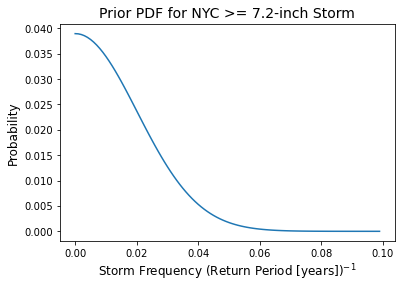

In [21]:
plt.plot(nyc_priors_df['Storm Probability'],nyc_priors_df['PDF'])
plt.xlabel('Storm Frequency (Return Period [years])$^{-1}$')
plt.ylabel('Probability')
plt.title('Prior PDF for NYC >= 7.2-inch Storm') 

In [22]:
prior_expected = np.sum(nyc_priors_df['PDF'] * nyc_priors_df['Storm Probability'])


In [23]:

prior_cdf = np.cumsum(nyc_priors_df['PDF'])
f = interp1d(prior_cdf, nyc_priors_df['Storm Probability'],fill_value="extrapolate")
upper = f(0.975)
if f(0.025) < 0:
    lower = 0
else:
    lower = f(0.025)
print(upper)

0.04425069438219516


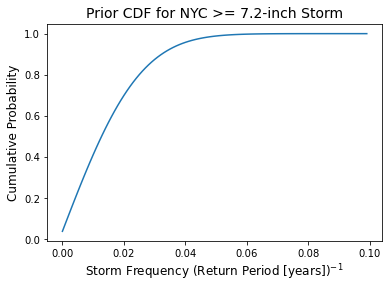

In [24]:
plt.plot(nyc_priors_df['Storm Probability'],prior_cdf)
plt.xlabel('Storm Frequency (Return Period [years])$^{-1}$')
plt.ylabel('Cumulative Probability')
plt.title('Prior CDF for NYC >= 7.2-inch Storm') 

g = interp1d(nyc_priors_df['Storm Probability'], prior_cdf,fill_value="extrapolate")

prior_expected_cdf = g(prior_expected)
upper_expected = g(upper)
lower_expected = g(lower)


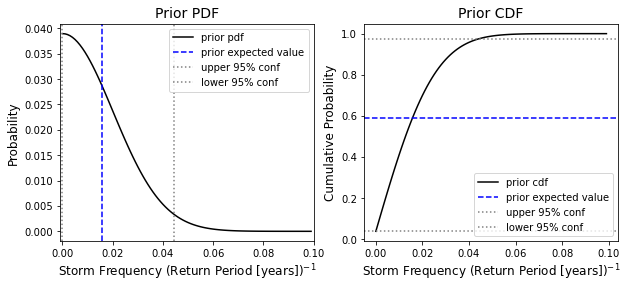

In [26]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,4))

ax1.plot(nyc_priors_df['Storm Probability'],nyc_priors_df['PDF'], 'k', label='prior pdf')
ax1.axvline(prior_expected, linestyle='--', color='b', label='prior expected value')
ax1.axvline(upper, linestyle=':', color='grey', label='upper 95% conf')
ax1.axvline(lower, linestyle=':', color='grey', label='lower 95% conf')
ax1.set_xlabel('Storm Frequency (Return Period [years])$^{-1}$')
ax1.set_ylabel('Probability')
ax1.set_title('Prior PDF')
ax1.set_xlim(-0.001,0.1)
ax1.legend(loc='upper right')

ax2.plot(nyc_priors_df['Storm Probability'],prior_cdf, 'k', label='prior cdf')
ax2.axhline(prior_expected_cdf, linestyle='--', color='b', label='prior expected value')
ax2.axhline(0.975, linestyle=':', color='grey', label='upper 95% conf')
ax2.axhline(lower_expected, linestyle=':', color='grey', label='lower 95% conf')
ax2.set_xlabel('Storm Frequency (Return Period [years])$^{-1}$')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('Prior CDF')
ax2.legend(loc='lower right')
fig.savefig('pdf_cdf.png')

In [27]:

print("upper 95% limit return period: {} years".format( np.round(1/upper,0)))
print("lower 95% limit return period is negative, thus there is no probability of this occuring.")
print("expected return period for >= 7.2-inch storm: {} years ".format( np.round(1/prior_expected)))
df_return_periods = pd.DataFrame(index = ['Prior', '1900-1999','2000-2009','2010-2019','2020-2021'], columns=['expected','lower','upper'])
period = 'Prior'
df_return_periods.at[period, 'expected'] = np.round(1/prior_expected,2)
df_return_periods.at[period, 'upper'] = np.round(upper,2)
df_return_periods.at[period, 'lower'] = 0


upper 95% limit return period: 23.0 years
lower 95% limit return period is negative, thus there is no probability of this occuring.
expected return period for >= 7.2-inch storm: 64.0 years 


The 95% interval falls between a strom frequency of 0 and 0.044. As detailed above, the upper 95% limit return period is 23.0 years. The lower 95% limit return period is negative, thus there is no probability of this occuring. The expected return period for >= 7.2-inch storm is 64.0 years 

**B. Apply Bayes' Theorem at each time period of interest (see table above) to update the the pdf for the 7.2-inch storm.**

**P(A|B) = P(B|A) * P(A) / P(B)**

In this problem, A is the true likelihood of the storm's occurrence, and B are the events we have observed. For the first time peirod, use the pdf from the data file as the prior pdf, P(A). For each subsequent time period, use the posterior pdf from the previous time period. The likelihood P(B|A = p) that the storm would be exceeded m times in n years (event B) for a storm probability p (event A = p) is given by: P(B|A = p) = scipy.stats.binom.pmf(m,n,p), where m is the number of storms, and n is the number of years.

**Calculate and plot the posterior pdfs of the 7.2-inch storm's probability after each time period.
Calculate the the mean and 95% confidence interval of the return period each time.**

In [10]:
x = nyc_priors_df['Storm Probability']

First lets set up our liklihood for the first time period:

In [11]:
# this is our P(B|A) for 1900-1999
storms = 1
years = 100
liklihood_100 = stats.binom.pmf(storms, years,x)

In [12]:
# this is  P(B|A)*P(A)
liklihood_100_prior = liklihood_100 * nyc_priors_df['PDF']
post_pdf_100 = liklihood_100_prior/np.nansum(liklihood_100_prior)
post_cdf_100 = np.cumsum(post_pdf_100)

In [13]:
post_expected = np.sum(post_pdf_100 * x)
print("expected value return period: {} years".format( np.round(1/post_expected,2)))

f = interp1d(post_cdf_100, x)
post_upper = f(0.975)
post_lower = f(0.025)
print("upper return period: {} years".format( np.round(1/post_upper,2)))
print("lower return period: {} years".format( np.round(1/post_lower,2)))
period = '1900-1999'
df_return_periods.at[period, 'expected'] = np.round(1/post_expected,2)
df_return_periods.at[period, 'upper'] = np.round(1/post_upper,2)
df_return_periods.at[period, 'lower'] = np.round(1/post_lower,2)

expected value return period: 73.71 years
upper return period: 30.09 years
lower return period: 708.4 years


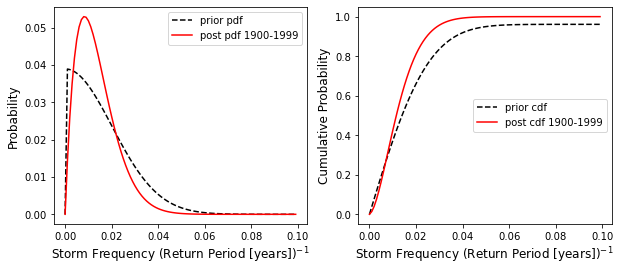

In [14]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,4))

ax1.plot(x,nyc_priors_df['PDF'], '--k', label='prior pdf')
ax1.plot(x,post_pdf_100, 'r', label='post pdf 1900-1999')
ax1.set_xlabel('Storm Frequency (Return Period [years])$^{-1}$')
ax1.set_ylabel('Probability')
ax1.legend(loc='upper right')


ax2.plot(x,prior_cdf, '--k', label='prior cdf')
ax2.plot(x,post_cdf_100, 'r', label='post cdf 1900-1999')
ax2.set_xlabel('Storm Frequency (Return Period [years])$^{-1}$')
ax2.set_ylabel('Cumulative Probability')
ax2.legend(loc='center right')

Now let's do the same for 2000-2009

In [15]:
# this is our P(B|A) for 2000-2009
storms = 1
years = 10
liklihood_10a = stats.binom.pmf(storms, years,x)

In [16]:
# this is  P(B|A)*P(A)
liklihood_10a_prior = liklihood_10a * post_pdf_100
post_pdf_10a = liklihood_10a_prior/np.nansum(liklihood_10a_prior)
post_cdf_10a = np.cumsum(post_pdf_10a)

In [17]:
post_expected = np.sum(post_pdf_10a * x)
print("expected value return period: {} years".format( np.round(1/post_expected,2)))

f = interp1d(post_cdf_10a, x)
post_upper = f(0.975)
post_lower = f(0.025)
print("upper return period: {} years".format( np.round(1/post_upper,2)))
print("lower return period: {} years".format( np.round(1/post_lower,2)))
period = '2000-2009'
df_return_periods.at[period, 'expected'] = np.round(1/post_expected,2)
df_return_periods.at[period, 'upper'] = np.round(1/post_upper,2)
df_return_periods.at[period, 'lower'] = np.round(1/post_lower,2)

expected value return period: 55.54 years
upper return period: 26.07 years
lower return period: 267.25 years


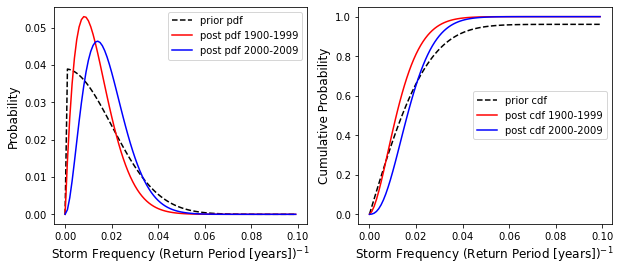

In [18]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,4))

ax1.plot(x,nyc_priors_df['PDF'], '--k', label='prior pdf')
ax1.plot(x,post_pdf_100, 'r', label='post pdf 1900-1999')
ax1.plot(x,post_pdf_10a, 'b', label='post pdf 2000-2009')
ax1.set_xlabel('Storm Frequency (Return Period [years])$^{-1}$')
ax1.set_ylabel('Probability')
ax1.legend(loc='upper right')


ax2.plot(x,prior_cdf, '--k', label='prior cdf')
ax2.plot(x,post_cdf_100, 'r', label='post cdf 1900-1999')
ax2.plot(x,post_cdf_10a, 'b', label='post cdf 2000-2009')
ax2.set_xlabel('Storm Frequency (Return Period [years])$^{-1}$')
ax2.set_ylabel('Cumulative Probability')
ax2.legend(loc='center right')

And now for 2010 - 2019:

In [19]:
# this is our P(B|A) for 2000-2009
storms = 4
years = 10
liklihood_10b = stats.binom.pmf(storms, years,x)

In [20]:
# this is  P(B|A)*P(A)
liklihood_10b_prior = liklihood_10b * post_pdf_10a
post_pdf_10b = liklihood_10b_prior/np.nansum(liklihood_10b_prior)
post_cdf_10b = np.cumsum(post_pdf_10b)

In [21]:
period = '2010-2019'
post_expected = np.sum(post_pdf_10b * x)
print("expected value return period: {} years".format( np.round(1/post_expected,2)))

f = interp1d(post_cdf_10b, x)
post_upper = f(0.975)
post_lower = f(0.025)
print("upper return period: {} years".format( np.round(1/post_upper,2)))
print("lower return period: {} years".format( np.round(1/post_lower,2)))
df_return_periods.at[period, 'expected'] = np.round(1/post_expected,2)
df_return_periods.at[period, 'upper'] = np.round(1/post_upper,2)
df_return_periods.at[period, 'lower'] = np.round(1/post_lower,2)

expected value return period: 29.97 years
upper return period: 17.98 years
lower return period: 67.97 years


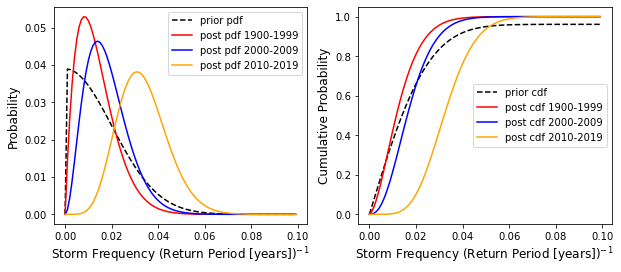

In [22]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,4))

ax1.plot(x,nyc_priors_df['PDF'], '--k', label='prior pdf')
ax1.plot(x,post_pdf_100, 'r', label='post pdf 1900-1999')
ax1.plot(x,post_pdf_10a, 'b', label='post pdf 2000-2009')
ax1.plot(x,post_pdf_10b, 'orange', label='post pdf 2010-2019')
ax1.set_xlabel('Storm Frequency (Return Period [years])$^{-1}$')
ax1.set_ylabel('Probability')
ax1.legend(loc='upper right')


ax2.plot(x,prior_cdf, '--k', label='prior cdf')
ax2.plot(x,post_cdf_100, 'r', label='post cdf 1900-1999')
ax2.plot(x,post_cdf_10a, 'b', label='post cdf 2000-2009')
ax2.plot(x,post_cdf_10b, 'orange', label='post cdf 2010-2019')
ax2.set_xlabel('Storm Frequency (Return Period [years])$^{-1}$')
ax2.set_ylabel('Cumulative Probability')
ax2.legend(loc='center right')

Lastly, we will do the update with the last few years:

In [23]:
# this is our P(B|A) for 2000-2009
storms = 1
years = 2
liklihood_2 = stats.binom.pmf(storms, years,x)

In [24]:
# this is  P(B|A)*P(A)
liklihood_2_prior = liklihood_2 * post_pdf_10b
post_pdf_2 = liklihood_2_prior/np.nansum(liklihood_2_prior)
post_cdf_2 = np.cumsum(post_pdf_2)

In [25]:
period = '2020-2021'
post_expected = np.sum(post_pdf_2 * x)
print("expected value return period: {} years".format( np.round(1/post_expected,2)))

f = interp1d(post_cdf_2, x)
post_upper = f(0.975)
post_lower = f(0.025)
print("upper return period: {} years".format( np.round(1/post_upper,2)))
print("lower return period: {} years".format( np.round(1/post_lower,2)))
df_return_periods.at[period, 'expected'] = np.round(1/post_expected,2)
df_return_periods.at[period, 'upper'] = np.round(1/post_upper,2)
df_return_periods.at[period, 'lower'] = np.round(1/post_lower,2)

expected value return period: 27.35 years
upper return period: 16.94 years
lower return period: 57.66 years


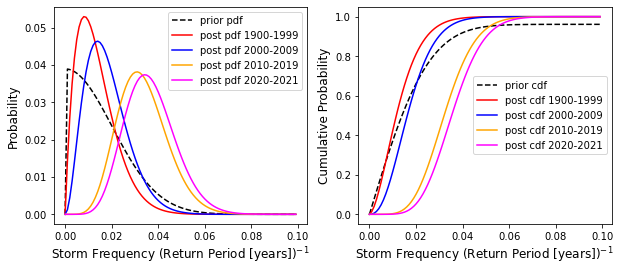

In [26]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,4))

ax1.plot(x,nyc_priors_df['PDF'], '--k', label='prior pdf')
ax1.plot(x,post_pdf_100, 'r', label='post pdf 1900-1999')
ax1.plot(x,post_pdf_10a, 'b', label='post pdf 2000-2009')
ax1.plot(x,post_pdf_10b, 'orange', label='post pdf 2010-2019')
ax1.plot(x,post_pdf_2, 'magenta', label='post pdf 2020-2021')
ax1.set_xlabel('Storm Frequency (Return Period [years])$^{-1}$')
ax1.set_ylabel('Probability')
ax1.legend(loc='upper right')


ax2.plot(x,prior_cdf, '--k', label='prior cdf')
ax2.plot(x,post_cdf_100, 'r', label='post cdf 1900-1999')
ax2.plot(x,post_cdf_10a, 'b', label='post cdf 2000-2009')
ax2.plot(x,post_cdf_10b, 'orange', label='post cdf 2010-2019')
ax2.plot(x,post_cdf_2, 'magenta', label='post cdf 2020-2021')
ax2.set_xlabel('Storm Frequency (Return Period [years])$^{-1}$')
ax2.set_ylabel('Cumulative Probability')
ax2.legend(loc='center right')

**C. How much did the mean and 95% confidence interval return period change from the original prior return period to 2021? What does this indicate about the “true” frequency of the 7.2-inch-storm? To what k-year storm does this mean correspond to now?**

Lets look at the dataframe made to track expected 95% CI values, but only for the initial period and the last period:

In [27]:
print('Each return period is reported in years:')
df_return_periods[df_return_periods.index.isin(['Prior','2020-2021'])]

Each return period is reported in years:


,expected,lower,upper
Prior,63.78,0,73.2
2020-2021,27.35,57.66,16.94


The expected value of the original prior return period for the >= 7.2-inch storm is approximately 64 years. With the bayesian updating, the expected return period from 2020-2021 is now approximately 27 years. The PDF has shifted significantly to a much shorter storm return interval that is less than half of what it had been for the original prior PDF. The lower 95% confidence interval is now even below the original prior's expected value, at approximayely 58 years. The upper 95% confidence interval depicts a storm return interval of approximately 17 years. It is quite astounding how drastically the pdf for this design storm has shifted in such a short period of time.

# Problem 2 - Project Update

**A. Create 2-3 plots that illustrate your data. These can be time-series plots, histograms, CDFs, whatever is relevant to your data and your problem.**

These first plots show the mean SWE of our pre-fire sites and SWE 5 years following fire with the x-axis being water year. The plot on the left is the burned site, and the plot on the right is unburned. We performed these fore 5 paired locations. Here are two locations:
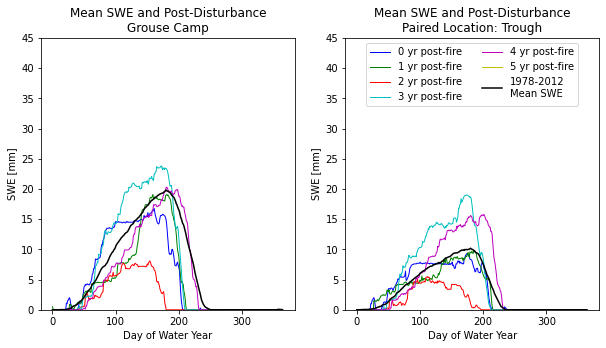
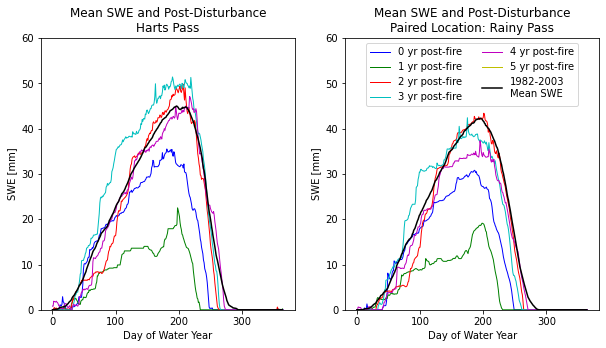

Additionally, we plotted up boxplots at a few of the paired locations before and after fire:

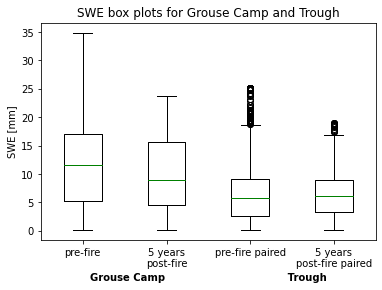
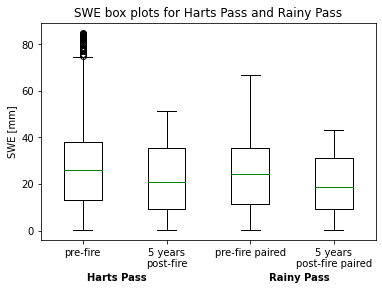

Lastly, we calculated the snow melt out dates for each year at the burned locations:

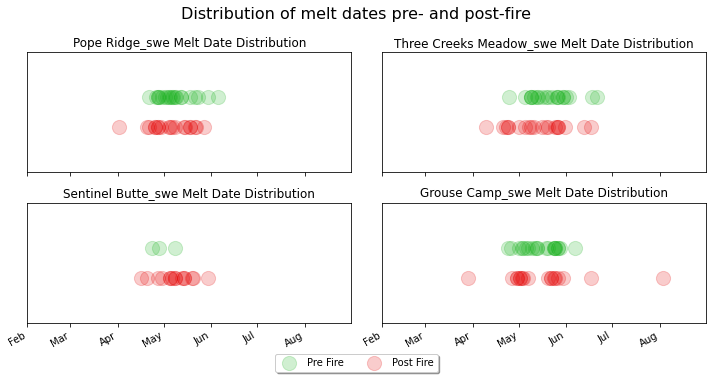

**B. Discuss the quality of your data. Do you need to take into account any erroneous values or uncertain numbers before you start your statistics?**
- We are not too concerned with our data quality from SNOTEL sites because these telemetry sites are part of a wide and robust system that has been used and trusted as ground truth values for decades.
- With respect to snow dissapearance dates, we are on the look out for potential errors in our calculations due to early or late season storms.
- We did have to filter out NaN values for days certain telemetry systems were not recording. Additionally, we ensured that errant data quality flags were removed from the data sets prior to loading them up.

**C. Write down at least two very specific questions that you will answer with your data. For each question, write down which statistical tools you will use to help answer it.**
1. Does a fire significantly influence the snow dissapearance date relative to years prior to a fire and compared to an unburned, nearby location?
- ANOVA. Hypothesis testing and linear regression. Possibly employ difference in differences method.

1a. (Pending the analysis from question 1) Does fire severity, as measured by differential soil burn severity, influence snow dissapearance dates?
- ANOVA.

2. How does a fire influence SWE relative to previous SWE values and an unburned, nearby location?
- ANOVA. Hypothesis testing and linear regression. Possibly employ difference in differences method.

**D. Based on what you have so far, do you think that your project scope is about right for a 10 page paper, or do you feel that you need to either simplify things to make it shorter or add complexity to make it longer? If you feel adjustments are needed, how to you plan to address this issue?**
- the data available for logged sites is very minimal and in very low snow areas, so we have opted to remove logging disturbance from our study and only focus on disturbance due to fire. We think we have a good amount of work to write a 10 page paper. 
- if we have additional time and space, we would also like to analyze how long after a fire impacts on swe is seen (depending on if we can measure impacts using our methodology).

**E. What do you anticipate being the most difficult parts of your term project? Do you have questions you would like help with or advice on? Write them here.**

We anticipate our biggest challenges to be as follows:
- working with small sample sizes and deciding how long after a fire we want to analyze. Literature generally points to between 3 and 5 years
- accounting for inter-annual precipitation variability
- Intrinsic variability between sites, especially the paired locations we are using as proxy unburned sites

A few questions we have: 
When comparing statistics for snow variables, is it okay to filter out no-snow values? Or is that discouraged?
Is comparing April 1 SWE the "gold standard" for year-over-year direct comparisons of SWE?